# Project Description
This project focuses on the classification of satellite imagery into 2 classes, "wildfire" or "no wildfire". The dataset used for this project comes from the Kaggle dataset “Wildfire Prediction Dataset (Satellite Images)” and was sourced from the Canadian Government’s Forest Fires Open Data Portal. It includes satellite images of size 350x350 pixels categorized into two classes :
- Wildfire: 22,710 images
- No Wildfire: 20,140 images

To facilitate training, the dataset was split into:
- Train: ~70%
- Validation: ~15%
- Test: ~15%

This project aimed to develop a custom convolutional neural network (CNN) capable of classifying whether a given image represents a wildfire area or not. The custom model will be compared with 2 others models : a Transfer Learning model (with ResNet) and a Data Augmentation model. These models could assist in rapid wildfire detection and prevent disaster spread, or risk analysis from new satellite images.


# Imports


In [1]:
# Global imports
import os
import random

# Handling data imports
import numpy as np
import pandas as pd
import cv2
from PIL import ImageFile

# Visualization imports
import matplotlib.pyplot as plt

# Deep learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import albumentations as transform

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print("Modules loaded successfully !")

2025-09-08 02:13:08.411265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757297588.660417      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757297588.729709      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modules loaded successfully !


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Data processing

In [2]:
# Define the directories of each set
dir = '/kaggle/input/wildfire-prediction-dataset'
train_dir = '/kaggle/input/wildfire-prediction-dataset/train'
val_dir = '/kaggle/input/wildfire-prediction-dataset/valid'
test_dir = '/kaggle/input/wildfire-prediction-dataset/test'

print("Directories defined !")

Directories defined !


In [3]:
# Function to display a sample of the satellite images of each set
def display_random_sample(dataset_dir):
    classes = os.listdir(dataset_dir)  # List of class directories
    plt.figure(figsize=(10, 10))       # Adjust the figure size if needed

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)                # Get all images in the class folder
        random_image = random.choice(image_files)          # Select a random image
        img_path = os.path.join(class_dir, random_image)

        # Load the image with its original size
        img = load_img(img_path)

        # Display the image
        plt.subplot(1, len(classes), i + 1)                       # Display images in a single row
        plt.imshow(img)
        plt.axis('off')                                           # Turn off axis for better visualization
        plt.title(f"{class_name} ({img.size[0]}x{img.size[1]})")  # Show class name and image size

    plt.show()

Training set contains 30250 images : 15750 wildfire and 14500 nowildfire images.


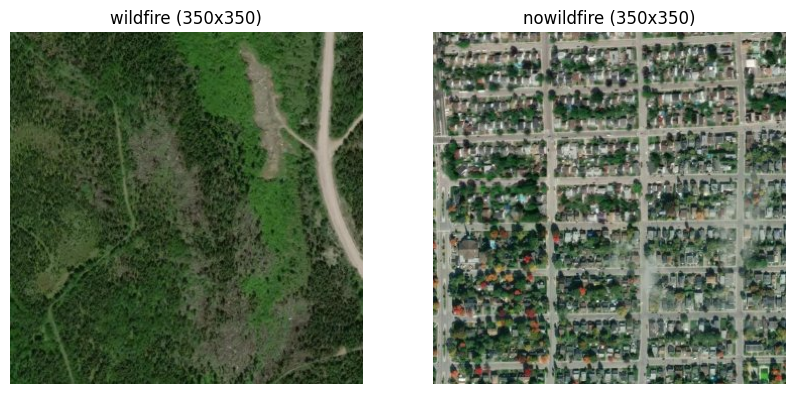

Validation set contains 6300 images : 3480 wildfire and 2820 nowildfire images.


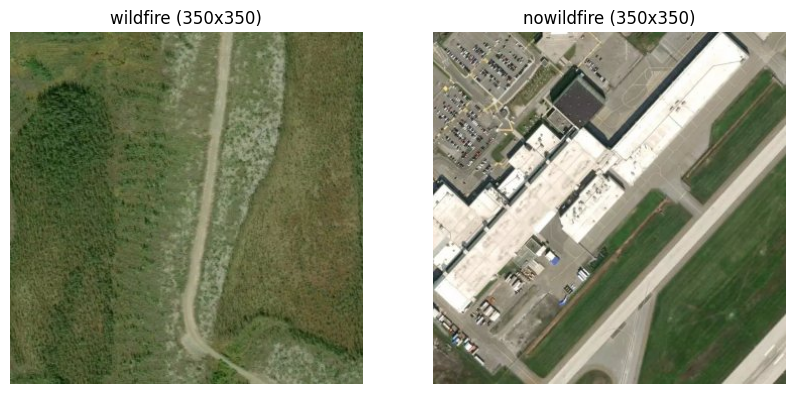

Test set contains 6300 images : 3480 wildfire and 2820 nowildfire images.


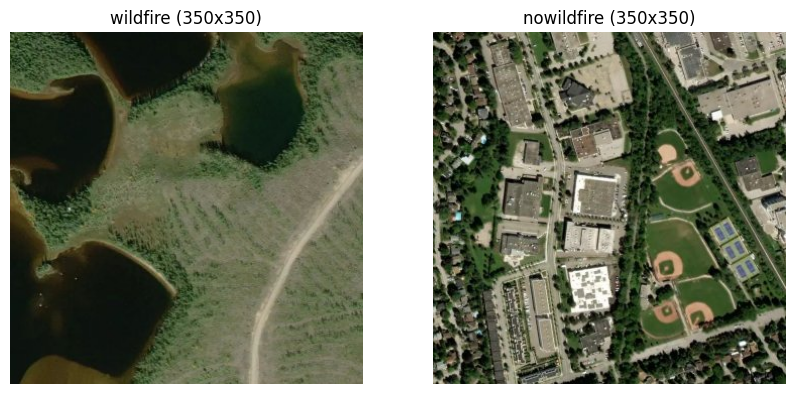

In [4]:
# Display the samples and computing size of sets
num_wf_train = len(os.listdir(os.path.join(train_dir,"wildfire")))
num_nwf_train = len(os.listdir(os.path.join(train_dir,"nowildfire")))
print(f"Training set contains {num_wf_train+num_nwf_train} images : {num_wf_train} wildfire and {num_nwf_train} nowildfire images.")
display_random_sample(train_dir)

num_wf_val = len(os.listdir(os.path.join(val_dir,"wildfire")))
num_nwf_val = len(os.listdir(os.path.join(val_dir,"nowildfire")))
print(f"Validation set contains {num_wf_val+num_nwf_val} images : {num_wf_val} wildfire and {num_nwf_val} nowildfire images.")
display_random_sample(val_dir)

num_wf_test = len(os.listdir(os.path.join(test_dir,"wildfire")))
num_nwf_test = len(os.listdir(os.path.join(test_dir,"nowildfire")))
print(f"Test set contains {num_wf_test+num_nwf_test} images : {num_wf_test} wildfire and {num_nwf_test} nowildfire images.")
display_random_sample(test_dir)

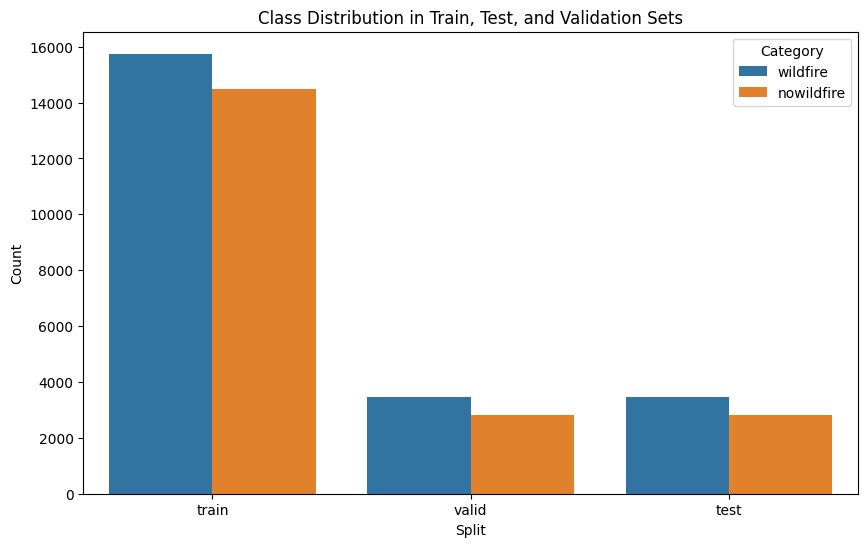

In [5]:
#### Plot class distribution : to be modified to display the distibution in my case
def plot_class_distribution(data_dir, splits, categories):

    image_counts = {}

    for split in splits:
        for category in categories:
            key = f"{split}_{category}"
            path = os.path.join(data_dir, split, category)
            image_counts[key] = len(os.listdir(path))

    data = []
    for split in splits:
        for category in categories:
            count = image_counts[f"{split}_{category}"]
            data.append({'Split': split, 'Category': category, 'Count': count})

    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Split', y='Count', hue='Category', data=df)
    plt.title('Class Distribution in Train, Test, and Validation Sets')
    plt.show()

splits = ['train', 'valid', 'test']
categories = ['wildfire', 'nowildfire']
plot_class_distribution(dir, splits, categories)

In [6]:
# Rescaling and loading the data
BATCH_SIZE = 32
TARGET_SIZE = (128,128)

datagen = ImageDataGenerator(dtype = 'float32', rescale = 1./255.)
train_generator = datagen.flow_from_directory(train_dir,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

val_generator = datagen.flow_from_directory(val_dir,
                                                   shuffle = False,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

test_generator = datagen.flow_from_directory(test_dir,
                                                   shuffle = False,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


# Data Augmentation

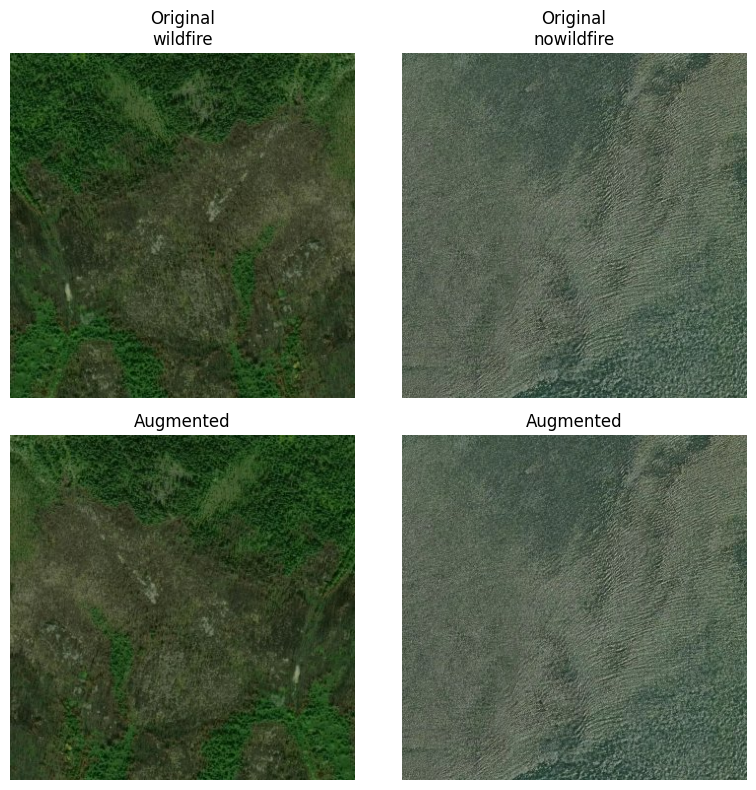

In [7]:
# Augmented data
def augmentation_image(image):
  aug = transform.Compose([
        transform.HorizontalFlip(p=0.5),
        transform.VerticalFlip(p=0.5),
        transform.Rotate(limit=75, always_apply = True, border_mode=cv2.BORDER_REFLECT_101)
    ])
  return aug(image=image)['image']

def display_augmented_sample(dataset_dir):
  classes = os.listdir(dataset_dir)           # List of class directories
  plt.figure(figsize=(len(classes) * 4, 8))   # Width scales with number of classes

  for i, class_name in enumerate(classes):
      class_dir = os.path.join(dataset_dir, class_name)
      image_files = os.listdir(class_dir)
      random_image = random.choice(image_files)
      img_path = os.path.join(class_dir, random_image)

      # Load image
      image_bgr = cv2.imread(img_path)
      image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
      augmented_image = augmentation_image(image_rgb)

      # Plot original
      plt.subplot(2, len(classes), i + 1)
      plt.imshow(image_rgb)
      plt.axis('off')
      plt.title(f"Original\n{class_name}")

      # Plot augmented
      plt.subplot(2, len(classes), i + 1 + len(classes))
      plt.imshow(augmented_image)
      plt.axis('off')
      plt.title("Augmented")

  plt.tight_layout()
  plt.show()

display_augmented_sample(train_dir)

In [8]:
# Rescaling and loading the augemnted data
datagen_augm_train = ImageDataGenerator(dtype = 'float32', rescale = 1./255., preprocessing_function = augmentation_image)
train_generator_augm = datagen_augm_train.flow_from_directory(train_dir,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

datagen_augm_test = ImageDataGenerator(dtype = 'float32', rescale = 1./255.)
val_generator_augm = datagen_augm_test.flow_from_directory(val_dir,
                                                   shuffle = False,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

test_generator_augm = datagen_augm_test.flow_from_directory(test_dir,
                                                   shuffle = False,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = TARGET_SIZE,
                                                   class_mode = 'binary')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


# Creation of Models

1. build the model with Sequential API : used when we have one input that goes from top to bottom to one output
2. add layer to our model following an architecture like such :
    - Conv2D(number_filter, size_filter(pixel,pixel), stride, activation, padding(keep the same size as the previous layer), input_shape) : performs convolution operation.
    - MaxPooling2D(pool_size = 2) : takes the maximum value and condense the information.
    - Flatten : condenses and flatten the information to a single value.
    - Dense(number_neurons, activation) : fully connected layers.
    - Dropout : modifies the propagation probabilty of the signals of neurons.
    - BatchNormalization : applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
3. compile the model by telling it how to learn (Adam optimizer + binary_crossentropy loss) and what to report (accuracy, recall).     

In [9]:
# Model 1 : Simple Model (baseline)
weight_decay = 1e-3

def create_baseline_model():
  model = Sequential()

  model.add(Conv2D(8, (3, 3), activation = 'relu', padding='same', input_shape=(128, 128, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(16 , (3, 3), activation = 'relu', padding='same',))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Conv2D(32 , (3, 3), activation = 'relu', kernel_regularizer = regularizers.l2(weight_decay) ))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Dropout(0.4)),
  model.add(Flatten())
  model.add(Dense(200,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1,activation='sigmoid'))

  # Visualize the model
  model.summary()

  # Compile the model
  model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4, decay= 1e-5),
              metrics=['accuracy','recall'])

  return model

model1 = create_baseline_model()

2025-09-08 02:14:10.250344: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │       1,440,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,446,657 (5.52 MB)

 Trainable params: 1,446,545 (5.52 MB)

 Non-trainable params: 112 (448.00 B)

In [20]:
# Model 3 : Data Augmentation Model
model3 = create_baseline_model()
Model: "sequential_1"

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │       1,440,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,446,657 (5.52 MB)

 Trainable params: 1,446,545 (5.52 MB)

 Non-trainable params: 112 (448.00 B)

# Train the model
- training : images used for the training step
- epochs : how many times the model is going to go over the whole dataset
- validation : images used for the validation step
- callbacks : everything that is done after the passing of one epoch
    - EarlyStopping : stop the training if validation loss didn't decrease for 5 consecutive epochs
- verbose : to see how the model progresses during training

In [10]:
# Train the model 1 : baseline
ImageFile.LOAD_TRUNCATED_IMAGES = True

early_stopping = EarlyStopping(monitor= 'val_loss', patience= 2)

history1 = model1.fit(train_generator,
                    epochs = 3,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [early_stopping]
                   )

Epoch 1/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 350s 363ms/step - accuracy: 0.8825 - loss: 0.3937 - recall: 0.9045 - val_accuracy: 0.9444 - val_loss: 0.1916 - val_recall: 0.9437
Epoch 2/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 252s 266ms/step - accuracy: 0.9257 - loss: 0.2239 - recall: 0.9436 - val_accuracy: 0.9478 - val_loss: 0.1679 - val_recall: 0.9489
Epoch 3/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 251s 265ms/step - accuracy: 0.9344 - loss: 0.1962 - recall: 0.9520 - val_accuracy: 0.9483 - val_loss: 0.1582 - val_recall: 0.9422


In [22]:
# Train the model 3 : augmented data
history3 = model3.fit(train_generator_augm,
                    epochs = 3,
                    verbose = 1,
                    validation_data = val_generator_augm,
                    callbacks = [early_stopping]
                   )

Epoch 1/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 267s 281ms/step - accuracy: 0.9249 - loss: 0.2176 - recall: 0.9369 - val_accuracy: 0.9414 - val_loss: 0.1660 - val_recall: 0.9460
Epoch 2/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 283s 298ms/step - accuracy: 0.9314 - loss: 0.1951 - recall: 0.9415 - val_accuracy: 0.9454 - val_loss: 0.1715 - val_recall: 0.9221


# Visualize the results

In [23]:
# Display the graph of chosen metric
def plot_metrics(hist, metric_train, metric_val) :
  fig = plt.figure()
  plt.plot(hist.history[metric_train], color='teal', label=metric_train)
  plt.plot(hist.history[metric_val], color='orange', label=metric_val)
  fig.suptitle(metric_train, fontsize=20)
  plt.legend(loc="upper left")
  plt.show()

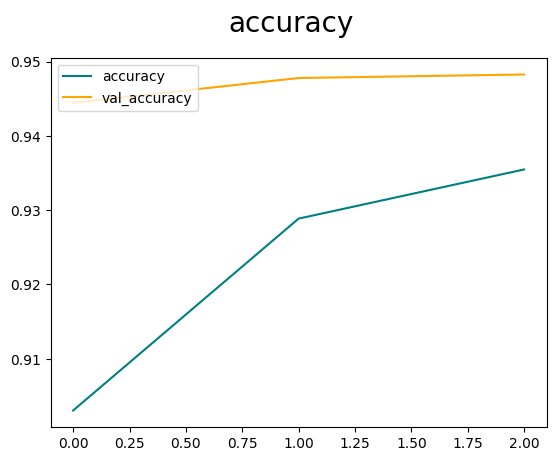

In [15]:
plot_metrics(history1, 'accuracy', 'val_accuracy')

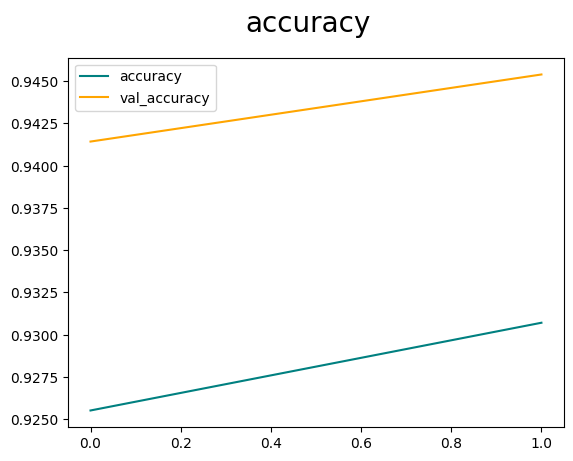

In [24]:
plot_metrics(history3, 'accuracy', 'val_accuracy')

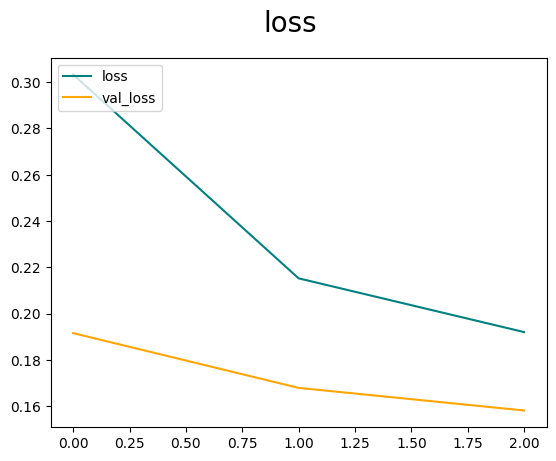

In [25]:
plot_metrics(history1, 'loss', 'val_loss')

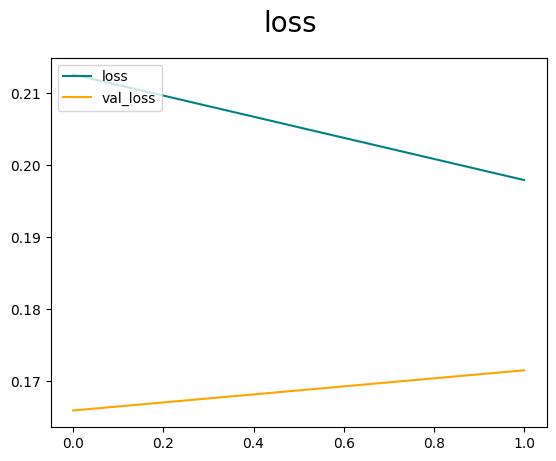

In [26]:
plot_metrics(history3, 'loss', 'val_loss')

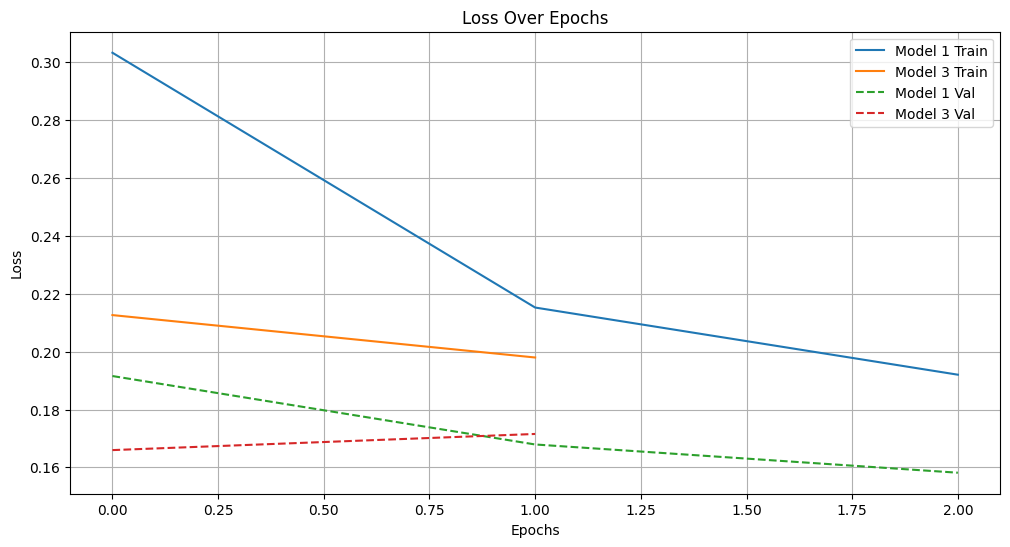

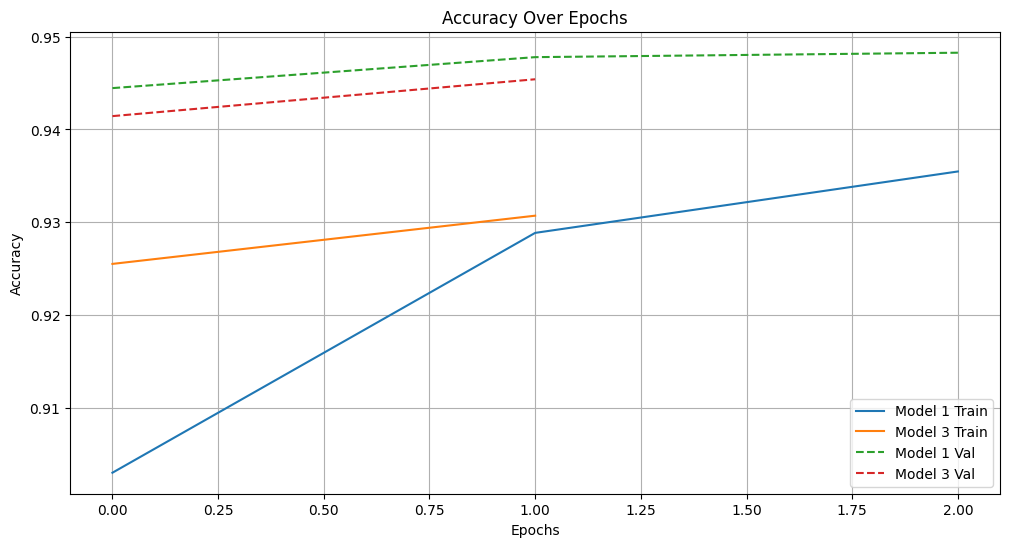

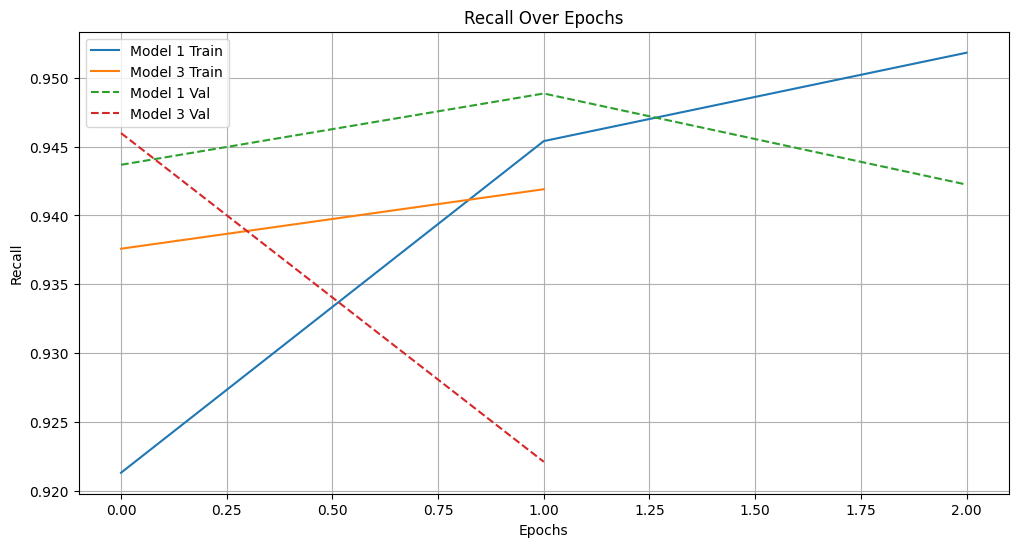

In [28]:
# Display the metrics of all models in the same graph

# List of history objects and labels
histories = [history1, history3]
labels = ['Model 1', 'Model 3']

# Define metrics to plot
metrics = ['loss', 'accuracy', 'recall']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))

    # Plot training metric
    for i, history in enumerate(histories):
        plt.plot(history.history[metric], label=f'{labels[i]} Train')

    # Plot validation metric
    for i, hist in enumerate(histories):
        plt.plot(hist.history[f'val_{metric}'], linestyle='--', label=f'{labels[i]} Val')

    plt.title(f'{metric.capitalize()} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()


In [35]:
# Function to plot some random predictions
def plot_random_pred(true_classes, predicted_classes, class_labels, filepaths) :
  # To hold selected indices
  correct_indices = {}
  incorrect_indices = {}

  # Search through predictions
  for idx, (true, pred) in enumerate(zip(true_classes, predicted_classes)):
      if true == pred and true not in correct_indices:
          correct_indices[true] = idx
      elif true != pred and true not in incorrect_indices:
          incorrect_indices[true] = idx
      if len(correct_indices) == len(class_labels) and len(incorrect_indices) == len(class_labels):
          break  # Stop once we have one of each per class

  # Plot
  plt.figure(figsize=(12, 6))
  for i, class_id in enumerate(range(len(class_labels))):
      # Correct
      idx = correct_indices.get(class_id)
      if idx is not None:
          img = load_img(filepaths[idx], target_size=TARGET_SIZE)
          plt.subplot(2, len(class_labels), i+1)
          plt.imshow(img)
          plt.axis('off')
          plt.title(f"{class_labels[class_id]}", color='green')

      # Incorrect
      idx = incorrect_indices.get(class_id)
      if idx is not None:
          img = load_img(filepaths[idx], target_size=TARGET_SIZE)
          plt.subplot(2, len(class_labels), i+1+len(class_labels))
          plt.imshow(img)
          plt.axis('off')
          plt.title(f"True: {class_labels[true_classes[idx]]}\nPred: {class_labels[predicted_classes[idx]]}", color='red')

  plt.tight_layout()
  plt.show()

# Evaluation of the models and Result analysis

197/197 ━━━━━━━━━━━━━━━━━━━━ 54s 276ms/step


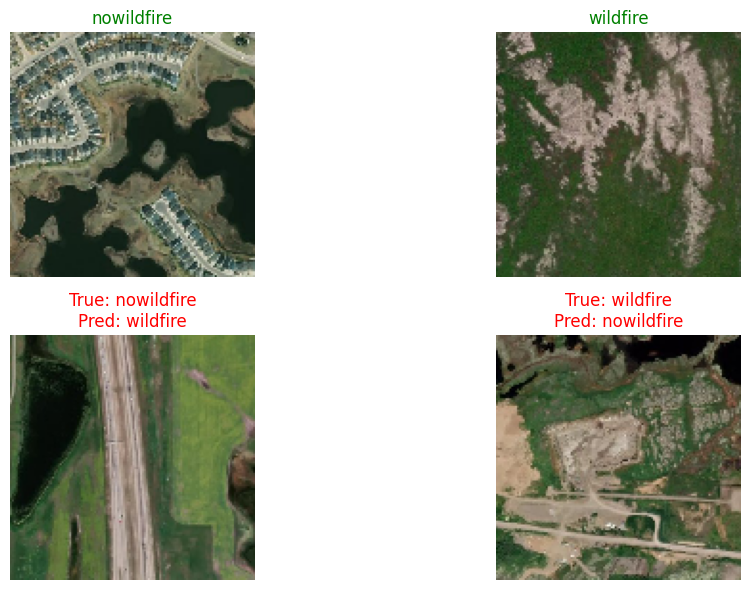

In [36]:
# Model 1
test_generator.reset()

filepaths = test_generator.filepaths
predictions = model1.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_random_pred(true_classes, predicted_classes, class_labels, filepaths)

In [37]:
# Model 2
test_generator_augm.reset()

filepaths3 = test_generator_augm.filepaths
predictions3 = model3.predict(test_generator_augm, verbose=1)
predicted_classes3 = (predictions3 > 0.5).astype("int32").flatten()
true_classes3 = test_generator_augm.classes
class_labels3 = list(test_generator_augm.class_indices.keys())

197/197 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step


In [39]:
# Confusion matrix
def class_report(true_classes, predicted_classes, class_labels) :
  cm = confusion_matrix(true_classes, predicted_classes)

  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.show()

  # Classification report
  print(classification_report(true_classes, predicted_classes, target_names=class_labels))

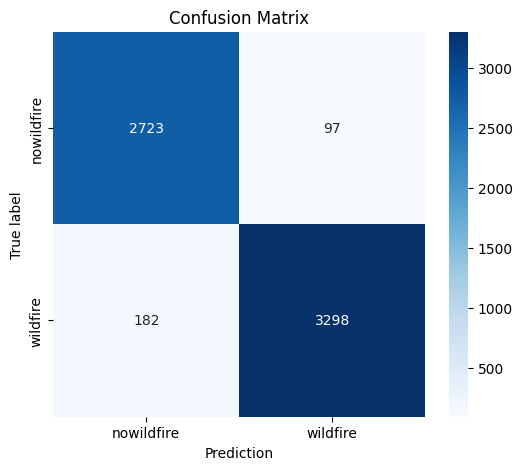

              precision    recall  f1-score   support

  nowildfire       0.94      0.97      0.95      2820
    wildfire       0.97      0.95      0.96      3480

    accuracy                           0.96      6300
   macro avg       0.95      0.96      0.96      6300
weighted avg       0.96      0.96      0.96      6300



In [40]:
# Model 1
class_report(true_classes, predicted_classes, class_labels)

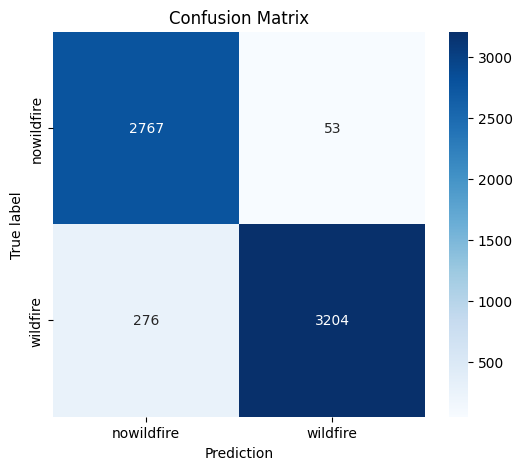

              precision    recall  f1-score   support

  nowildfire       0.91      0.98      0.94      2820
    wildfire       0.98      0.92      0.95      3480

    accuracy                           0.95      6300
   macro avg       0.95      0.95      0.95      6300
weighted avg       0.95      0.95      0.95      6300



In [41]:
# Model 2
class_report(true_classes3, predicted_classes3, class_labels3) # Model 2

In [32]:
# 0. imports & basic setup
# ============================================
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # 安静一点

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


In [40]:
# 0. imports & quiet TF
# ============================================
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [42]:
# 1. 路径设置（这里改成你自己的）
#    确保下面这三个目录存在：
#    BASE_DIR/train/nowildfire
#    BASE_DIR/train/wildfire
#    BASE_DIR/valid/...
#    BASE_DIR/test/...
# ============================================
BASE_DIR = '/kaggle/input/wildfire-prediction-dataset'   # ← 改成你的实际名字

train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "valid")
test_dir  = os.path.join(BASE_DIR, "test")

print("train_dir:", train_dir)
print("val_dir :", val_dir)
print("test_dir:", test_dir)

# ============================================
# 2. 超参数（快训版）
# ============================================
IMG_SIZE = (96, 96)   # 小一点 → 快
BATCH_SIZE = 32
TIME_STEPS = 1
EPOCHS = 5
TRAIN_STEPS = 200     # 一轮只跑这么多
VAL_STEPS = 50


train_dir: /kaggle/input/wildfire-prediction-dataset/train
val_dir : /kaggle/input/wildfire-prediction-dataset/valid
test_dir: /kaggle/input/wildfire-prediction-dataset/test


In [43]:
# 3. 读数据（用 keras 的目录读取）
#    注意：这里只负责读，后面我们会 ignore_errors
# ============================================
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True,
)
class_names = raw_train_ds.class_names
print("Classes:", class_names)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False,
)

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False,
)

Found 30250 files belonging to 2 classes.
Classes: ['nowildfire', 'wildfire']
Found 6300 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.


In [44]:
# 4. 数据增强 + 归一化
# ============================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

def preprocess_train(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    images = data_augmentation(images)
    return images, labels

def preprocess_eval(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

train_ds = raw_train_ds.map(preprocess_train).apply(
    tf.data.experimental.ignore_errors()
)
val_ds = raw_val_ds.map(preprocess_eval).apply(
    tf.data.experimental.ignore_errors()
)
test_ds = raw_test_ds.map(preprocess_eval).apply(
    tf.data.experimental.ignore_errors()
)

In [45]:
# 5. 加时间维（防止重复加）
# ============================================
AUTOTUNE = tf.data.AUTOTUNE

def add_time_dim(images, labels):
    if images.shape.rank == 4:          # (B,H,W,C)
        images = tf.expand_dims(images, 1)  # -> (B,1,H,W,C)
    return images, labels

train_ds = (
    train_ds
    .map(add_time_dim)
    .cache()
    .repeat()        # 训练集重复 → 不会跑完
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .map(add_time_dim)
    .cache()
    .prefetch(AUTOTUNE)
)
test_ds = (
    test_ds
    .map(add_time_dim)
    .prefetch(AUTOTUNE)
)

In [47]:
# 6. 这里换成“数文件夹”来做 class_weight，避免坏JPEG
# ============================================
def count_files(folder):
    if not os.path.isdir(folder):
        return 0
    return len([f for f in os.listdir(folder) if not f.startswith(".")])

train_nowildfire = count_files(os.path.join(train_dir, "nowildfire"))
train_wildfire   = count_files(os.path.join(train_dir, "wildfire"))

print("train nowildfire (0):", train_nowildfire)
print("train wildfire   (1):", train_wildfire)

neg = train_nowildfire if train_nowildfire > 0 else 1
pos = train_wildfire   if train_wildfire   > 0 else 1
total = neg + pos

class_weight = {
    0: total / (2.0 * neg),
    1: total / (2.0 * pos),
}
print("class_weight:", class_weight)

train nowildfire (0): 14500
train wildfire   (1): 15750
class_weight: {0: 1.043103448275862, 1: 0.9603174603174603}


In [48]:
# 7. 建一个“稍微强一点但还能快训”的 ConvLSTM
# ============================================
height, width = IMG_SIZE
channels = 3

inputs = keras.Input(shape=(TIME_STEPS, height, width, channels))

# 两层 ConvLSTM + BN
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inputs)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=False,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)

# 空间卷积
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1, 96, 96, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 1, 96, 96, 32)       │          40,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 96, 96, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 96, 96, 32)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 147456)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 147456)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      18,874,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,007,681 (72.51 MB)

 Trainable params: 19,007,553 (72.51 MB)

 Non-trainable params: 128 (512.00 B)

In [49]:
# 8. 训练（快训版）
# ============================================
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS,     # 限制一轮步数 → 快
    validation_data=val_ds,
    validation_steps=VAL_STEPS,
    class_weight=class_weight,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)


Epoch 1/5
 51/200 ━━━━━━━━━━━━━━━━━━━━ 13:24 5s/step - accuracy: 0.8026 - loss: 2.0903

2025-11-08 05:49:23.283181: E tensorflow/core/lib/jpeg/jpeg_mem.cc:329] Premature end of JPEG data. Stopped at line 46/350


200/200 ━━━━━━━━━━━━━━━━━━━━ 1113s 5s/step - accuracy: 0.8317 - loss: 1.1266 - val_accuracy: 0.0025 - val_loss: 0.7238
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1101s 6s/step - accuracy: 0.8886 - loss: 0.3030 - val_accuracy: 0.4812 - val_loss: 0.6929
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1072s 5s/step - accuracy: 0.9133 - loss: 0.2446 - val_accuracy: 0.9831 - val_loss: 0.1575
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1045s 5s/step - accuracy: 0.9166 - loss: 0.2203 - val_accuracy: 0.9220 - val_loss: 0.2267
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1069s 5s/step - accuracy: 0.9167 - loss: 0.2106 - val_accuracy: 0.9375 - val_loss: 0.1539


In [50]:
# 9. 测试集评估
# ============================================
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

    127/Unknown 154s 1s/step - accuracy: 0.9576 - loss: 0.1082

2025-11-08 07:18:30.972130: E tensorflow/core/lib/jpeg/jpeg_mem.cc:329] Premature end of JPEG data. Stopped at line 126/350


196/196 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9530 - loss: 0.1226
Test accuracy: 0.9454371333122253


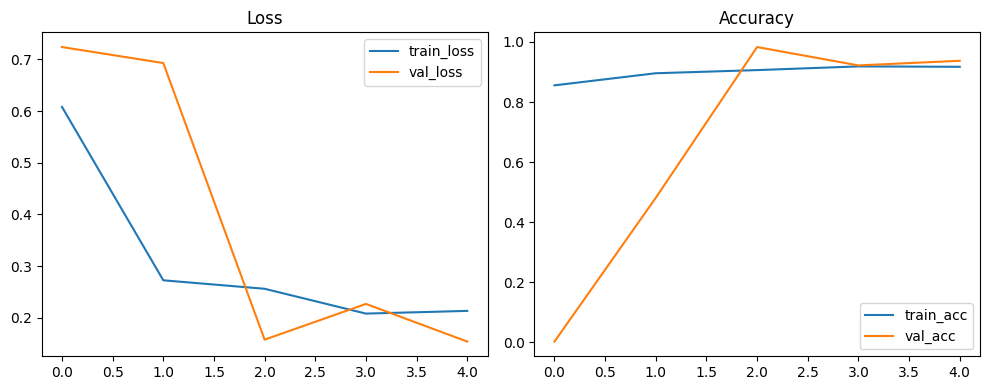

In [51]:
# 10. 训练曲线
# ============================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy")

plt.tight_layout()
plt.show()

In [52]:
# 11. 验证集扫阈值，找更好的 accuracy
# ============================================
all_true, all_prob = [], []
for i, (imgs, labels) in enumerate(val_ds.take(VAL_STEPS)):
    probs = model.predict(imgs, verbose=0).flatten()
    all_prob.extend(list(probs))
    all_true.extend(list(labels.numpy().astype(int)))

all_true = np.array(all_true)
all_prob = np.array(all_prob)

best_acc = 0.0
best_th = 0.5
for th in np.linspace(0.3, 0.7, 21):
    pred = (all_prob >= th).astype(int)
    acc = (pred == all_true).mean()
    if acc > best_acc:
        best_acc = acc
        best_th = th

print("Best val acc:", best_acc, "at threshold", best_th)

Best val acc: 0.95875 at threshold 0.7


2025-11-08 07:26:10.693154: E tensorflow/core/lib/jpeg/jpeg_mem.cc:329] Premature end of JPEG data. Stopped at line 126/350


Confusion matrix:
 [[2746   74]
 [ 324 3124]]


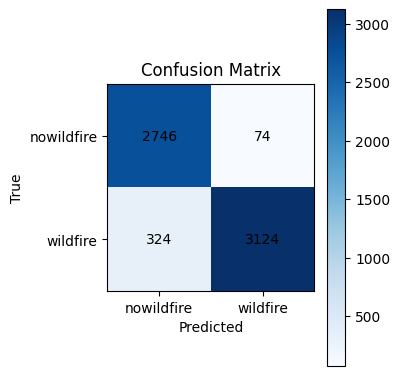

In [53]:
# 12. 用最优阈值做混淆矩阵
# ============================================
y_true, y_pred = [], []
for imgs, labels in test_ds:
    probs = model.predict(imgs, verbose=0).flatten()
    pred = (probs >= best_th).astype(int)
    y_pred.extend(list(pred))
    y_true.extend(list(labels.numpy().astype(int)))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = [0, 1]
plt.xticks(ticks, class_names)
plt.yticks(ticks, class_names)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Randomly skipping 9 batches from test_ds...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


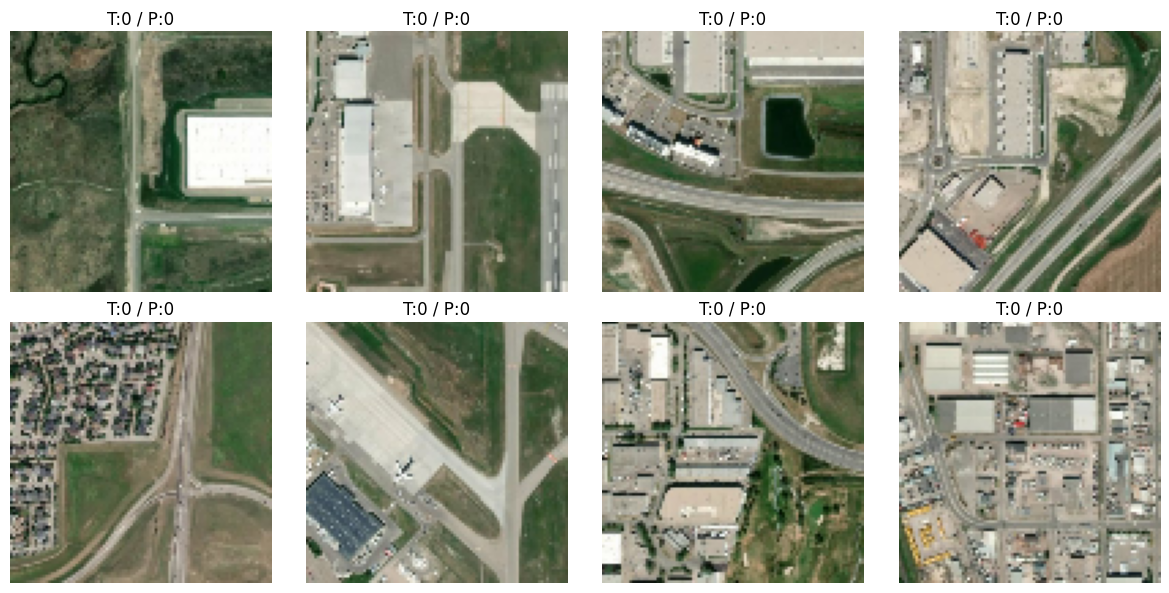

In [87]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# 想要最多跳过多少批，可以自己调
MAX_SKIP = 40
skip = random.randint(0, MAX_SKIP)
print(f"Randomly skipping {skip} batches from test_ds...")

current = 0
for imgs, labels in test_ds:
    if current < skip:
        current += 1
        continue

    # 到了我们想看的这一批
    # 预测
    probs = model.predict(imgs).flatten()
    thresh = best_th if "best_th" in globals() else 0.5
    preds = (probs >= thresh).astype(int)

    # 去掉时间维度 (B, H, W, C)
    imgs = tf.squeeze(imgs, axis=1)

    plt.figure(figsize=(12, 6))
    n_show = min(8, imgs.shape[0])
    for i in range(n_show):
        plt.subplot(2, 4, i + 1)
        pic = (imgs[i].numpy() * 255).astype("uint8")
        plt.imshow(pic)

        # 兼容 (1,) 或标量的 label
        lbl_arr = labels[i].numpy()
        true_label = int(lbl_arr[0]) if lbl_arr.ndim > 0 else int(lbl_arr)

        pred_label = int(preds[i])
        plt.title(f"T:{true_label} / P:{pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break  # 只画这一批
